<a href="https://colab.research.google.com/github/santule/ERA/blob/main/S17/VIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install torchinfo

In [12]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
from tqdm.auto import tqdm
from torchinfo import summary

In [2]:
import transformer

In [3]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/AI/ERA_course/session17

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/AI/ERA_course/session17


## 1 - LOAD DATA

In [4]:
# settings
batch_size = 16
num_workers = 2
IMG_SIZE = 224
height = 224
width = 224
color_channels = 3
patch_size = 16
epochs = 10
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
# Dataloader for the data
manual_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
])
train_dir = 'pizza_steak_sushi/train'
test_dir = 'pizza_steak_sushi/test'
train_data = datasets.ImageFolder(train_dir,transform = manual_transform)
test_data = datasets.ImageFolder(test_dir,transform = manual_transform)
class_names = train_data.classes
train_dataloader = DataLoader(train_data,batch_size = batch_size,
                              shuffle=True,num_workers=num_workers,
                              pin_memory=True)
test_dataloader = DataLoader(test_data,batch_size = batch_size,
                              shuffle=False,num_workers=num_workers,
                              pin_memory=True)

(-0.5, 223.5, 223.5, -0.5)

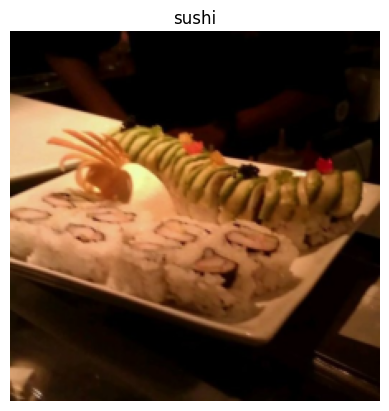

In [6]:
# sample image
img_batch, label_batch = next(iter(train_dataloader))

image, label = img_batch[0], label_batch[0]
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

## 2 - DEFINE MODEL AND OPTIMIZER

In [14]:
vit_model = transformer.ViT(num_classes = 3)
vit_model.to(device)
optimizer = torch.optim.Adam(params = vit_model.parameters(),lr=3e-3,betas=(0.9,0.999),
                             weight_decay=0.3)
loss_fn = torch.nn.CrossEntropyLoss()

summary(model= vit_model, input_size=(32,3,224,224), col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

## 3 - TRAIN MODEL

In [9]:
for epoch in tqdm(range(epochs)):

  # train model
  vit_model.train()
  train_loss, train_acc = 0,0
  for batch, (X,y) in enumerate(train_dataloader):
    X,y = X.to(device), y.to(device)
    y_pred = vit_model(X)

    loss = loss_fn(y_pred,y)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim = 1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

  train_loss = train_loss / len(train_dataloader)
  train_acc  = train_acc / len(train_dataloader)

  # test model
  vit_model.eval()
  test_loss, test_acc = 0,0

  with torch.inference_mode():
    for batch, (X,y) in enumerate(test_dataloader):
      X,y = X.to(device), y.to(device)
      y_pred = vit_model(X)

      loss = loss_fn(y_pred,y)
      test_loss += loss.item()
      y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim = 1)
      test_acc += (y_pred_class == y).sum().item() / len(y_pred)

    test_loss = train_loss / len(train_dataloader)
    test_acc  = train_acc / len(train_dataloader)


  print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7037 | train_acc: 0.4042 | test_loss: 0.1136 | test_acc: 0.0269
Epoch: 2 | train_loss: 1.2913 | train_acc: 0.3625 | test_loss: 0.0861 | test_acc: 0.0242
Epoch: 3 | train_loss: 1.1265 | train_acc: 0.4000 | test_loss: 0.0751 | test_acc: 0.0267
Epoch: 4 | train_loss: 1.2468 | train_acc: 0.3875 | test_loss: 0.0831 | test_acc: 0.0258
Epoch: 5 | train_loss: 1.2697 | train_acc: 0.3250 | test_loss: 0.0846 | test_acc: 0.0217
Epoch: 6 | train_loss: 1.1230 | train_acc: 0.3625 | test_loss: 0.0749 | test_acc: 0.0242
Epoch: 7 | train_loss: 1.1573 | train_acc: 0.3458 | test_loss: 0.0772 | test_acc: 0.0231
Epoch: 8 | train_loss: 1.1115 | train_acc: 0.3917 | test_loss: 0.0741 | test_acc: 0.0261
Epoch: 9 | train_loss: 1.1591 | train_acc: 0.3458 | test_loss: 0.0773 | test_acc: 0.0231
Epoch: 10 | train_loss: 1.1530 | train_acc: 0.3875 | test_loss: 0.0769 | test_acc: 0.0258
